# House Price Predictor: Regression
## Objectives
- Fit and evaluate a regression model to predict sale prices of inherited houses

## Inputs
- outputs/datasets/cleaned/HousePricesCleaned.csv
- instructions on which variables to use for data cleaning and feature engineering, found in data cleaning and feature engineering notebooks.

## Outputs
- Train set (features and target)
- Test set (features and target)
- ML pipeline to predict house prices
- Feature Importance Plot
- Model performance plot

## Conclusions
- As we hypothesized,
    - Size does matter: ['GrLivArea', 'GarageArea', 'TotalBsmtSF']
    - Quality is important: ['OverallQual' ]
    - Time matters: ['YearBuilt' ]

---

# Change working directory
We need to change the working directory from its current folder to its parent folder

In [1]:
import os

current_path = os.getcwd()
os.chdir(os.path.dirname(current_path))
current_path = os.getcwd()
current_path

'/workspace/CI_PP5'

# Load Data

In [3]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/HousePrices.csv") 
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# ML Pipeline: Regressor

In [4]:
from sklearn.pipeline import Pipeline

### Data Cleaning
from feature_engine.imputation import MeanMedianImputer, ArbitraryNumberImputer
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer

### Feature Engineering
from feature_engine import creation
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

### Feature Scaling
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PowerTransformer

### Feature Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Create ML Pipeline

In [5]:
# Mapping dictionaries for each feature
BsmtExposure_map = {'None': 0,'No': 0, 'Mn': 1, 'Av': 2, 'Gd': 3}
BsmtFinType1_map = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
GarageFinish_map = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
KitchenQual_map = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}

# Applying the mappings to the dataframe
df['BsmtExposure'] = df['BsmtExposure'].map(BsmtExposure_map)
df['BsmtFinType1'] = df['BsmtFinType1'].map(BsmtFinType1_map)
df['GarageFinish'] = df['GarageFinish'].map(GarageFinish_map)
df['KitchenQual'] = df['KitchenQual'].map(KitchenQual_map)

In [6]:
# To avoid future problems, lets drop these
df.drop(['EnclosedPorch', 'WoodDeckSF'], axis=1, inplace=True)

In [7]:
def PipelineOptimization(model):
    pipeline = Pipeline([
        # Data cleaning steps
        #('drop', DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ('mean_imputer', MeanMedianImputer(imputation_method='mean', variables=['BedroomAbvGr'])),
        ('median_imputer', MeanMedianImputer(imputation_method='median', variables=['LotFrontage', '2ndFlrSF', 'MasVnrArea', 'GarageYrBlt'])),
        ('arbitrary_number_imputer', ArbitraryNumberImputer(arbitrary_number=0, variables=['GarageFinish', 'BsmtFinType1'])),
        
        # Log and Power transformations
        ('log_transformer', vt.LogTransformer(variables=['GrLivArea', 'LotArea', 'LotFrontage'])),
        ('power_transformer', vt.PowerTransformer(variables=['GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'])),
        
        # Winsorizing
        ('winsorizer', Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['1stFlrSF', 'GarageArea', 'GrLivArea', 'TotalBsmtSF'])),

        # Smart correlated selection
        ('smart_corr_selection', SmartCorrelatedSelection(variables=None, method='spearman', threshold=0.8, selection_method='variance')),
        
        # Feature scaling
        ('scaler', StandardScaler()),
        
        # Feature selection
        ('feat_selection', SelectFromModel(model)),
        
        # Model
        ('model', model),
    ])
    return pipeline

- Custom Function from the Code Institute Walkthrough Project 2

In [8]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model=  PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train and Test Set

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1) ,
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("Train set:", x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)

Train set: (1168, 21) (1168,)
Test set: (292, 21) (292,)


## Grid Search CV - Sklearn
Use the default hyperparameters to find the mo

In [10]:
models_quick_search = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "LinearRegression": {},
    "DecisionTreeRegressor": {
        'model__max_depth': [None, 4, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
        'model__max_leaf_nodes': [None, 50],
    },
    "RandomForestRegressor": {
        'model__n_estimators': [100, 50, 140],
        'model__max_depth': [None, 4, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
        'model__max_leaf_nodes': [None, 50],
    },
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 50, 150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
    },
    "AdaBoostRegressor": {
        'model__n_estimators': [50, 25, 80, 150],
        'model__learning_rate': [1, 0.1, 2],
        'model__loss': ['linear', 'square', 'exponential'],
    },
    "GradientBoostingRegressor": {
        'model__n_estimators': [100, 50, 140],
        'model__learning_rate': [0.1, 0.01, 0.001],
        'model__max_depth': [3, 15, None],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
        'model__max_leaf_nodes': [None, 50],
    },
    "XGBRegressor": {
        'model__n_estimators': [30, 80, 200],
        'model__max_depth': [None, 3, 15],
        'model__learning_rate': [0.01, 0.1, 0.001],
        'model__gamma': [0, 0.1],
    },
}

Perform a initial quick search

In [11]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(x_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

Get the summary of the quick search

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate,model__loss,model__gamma
102,ExtraTreesRegressor,0.756495,0.813309,0.847343,0.037724,None,NaN,1,50,150,NaN,NaN,NaN
126,ExtraTreesRegressor,0.756495,0.813292,0.847257,0.037708,15,NaN,1,50,150,NaN,NaN,NaN
100,ExtraTreesRegressor,0.756687,0.812722,0.845706,0.036894,None,NaN,1,50,100,NaN,NaN,NaN
124,ExtraTreesRegressor,0.756687,0.812697,0.84558,0.036871,15,NaN,1,50,100,NaN,NaN,NaN
125,ExtraTreesRegressor,0.758212,0.812346,0.84372,0.035457,15,NaN,1,50,50,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,XGBRegressor,-6.311047,-5.091904,-4.386755,0.649231,None,NaN,NaN,NaN,30,0.001,NaN,0.1
409,XGBRegressor,-6.311047,-5.091904,-4.386755,0.649231,15,NaN,NaN,NaN,30,0.001,NaN,0
403,XGBRegressor,-6.311047,-5.091904,-4.386755,0.649231,None,NaN,NaN,NaN,30,0.001,NaN,0
433,XGBRegressor,-6.312306,-5.09271,-4.387771,0.649396,3,NaN,NaN,NaN,30,0.001,NaN,0.1


The results from the quick search indicates that the **ExtraTreesRegressor** performed best among the tested models, , with relatively high mean scores and low standard deviations.

In [13]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
    },
}


Perform the extensive search on the chosen model

In [14]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(x_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

Get the summary of the extensive search

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
5,ExtraTreesRegressor,0.756495,0.813309,0.847343,0.037724,None,1,50,150
29,ExtraTreesRegressor,0.756495,0.813292,0.847257,0.037708,15,1,50,150
4,ExtraTreesRegressor,0.756687,0.812722,0.845706,0.036894,None,1,50,100
28,ExtraTreesRegressor,0.756687,0.812697,0.84558,0.036871,15,1,50,100
27,ExtraTreesRegressor,0.758212,0.812346,0.84372,0.035457,15,1,50,50
3,ExtraTreesRegressor,0.758212,0.812346,0.84372,0.035457,None,1,50,50
2,ExtraTreesRegressor,0.647829,0.791248,0.852485,0.07559,None,1,2,150
25,ExtraTreesRegressor,0.655579,0.790627,0.860941,0.073972,15,1,2,100
24,ExtraTreesRegressor,0.664732,0.790494,0.854643,0.069362,15,1,2,50
1,ExtraTreesRegressor,0.636056,0.79036,0.856791,0.080535,None,1,2,100


Retrieve the best model and parameters

In [16]:
best_model_name = grid_search_summary.iloc[0]['estimator']
best_pipeline = grid_search_pipelines[best_model_name].best_estimator_
best_parameters = grid_search_pipelines[best_model_name].best_params_

print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {best_parameters}")

Best Model: ExtraTreesRegressor
Best Parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 50, 'model__n_estimators': 150}


Evaluate the best model on the test set

In [17]:
x_test_transformed = best_pipeline[:-1].transform(x_test)
y_pred = best_pipeline.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 1582361969.7167637
R^2 Score: 0.7708664425139911


In [18]:
best_regressor_pipeline = grid_search_pipelines[best_model_name].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('mean_imputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['BedroomAbvGr'])),
                ('median_imputer',
                 MeanMedianImputer(variables=['LotFrontage', '2ndFlrSF',
                                              'MasVnrArea', 'GarageYrBlt'])),
                ('arbitrary_number_imputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['GarageFinish',
                                                   'BsmtFinType1'])),
                ('log_transformer',
                 LogTransfor...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                  

# Assessment

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'KitchenQual', 'TotalBsmtSF', 'GarageArea']


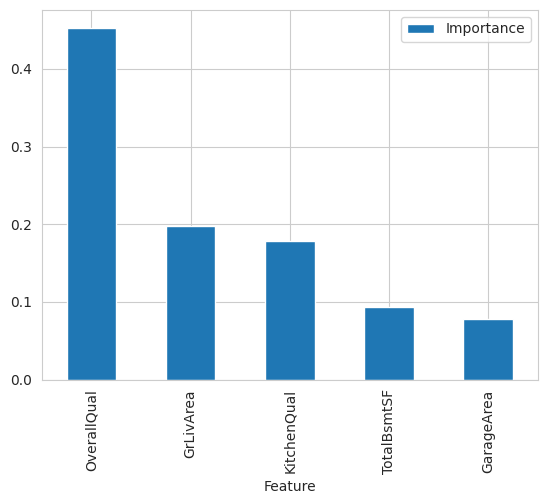

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 7 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps]).transform(x_train).columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

# Evaluation

In [21]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(x_train, y_train, x_test, y_test,pipeline):
  print("\033[4mTrain Set\033[0m")
  regression_evaluation(x_train,y_train,pipeline)
  print("\033[4mTest Set\033[0m")
  regression_evaluation(x_test,y_test,pipeline)

def regression_evaluation(x,y,pipeline):
  prediction = pipeline.predict(x)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(x_train, y_train, x_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(x_train)
  pred_test = pipeline.predict(x_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")
  #plt.savefig(f'docs/plots/regression_performance.png', bbox_inches='tight')  
  plt.show()

Train Set
R2 Score: 0.843
Mean Absolute Error: 19830.136
Mean Squared Error: 966331547.415
Root Mean Squared Error: 31085.874


Test Set
R2 Score: 0.771
Mean Absolute Error: 22227.812
Mean Squared Error: 1582361969.717
Root Mean Squared Error: 39778.914




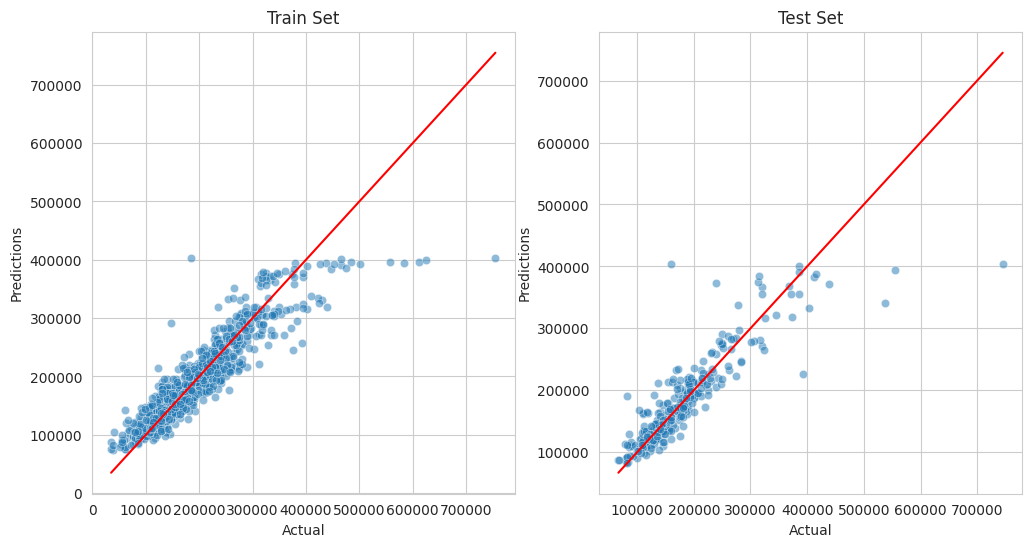

In [22]:
regression_performance(x_train, y_train, x_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(x_train, y_train, x_test, y_test, best_regressor_pipeline)

R2 score on the trainset (0.843) and test set (0.771) are pretty strong and above the busniess expectation of 0.75.

# Refit pipeline with best features
## Rewrite Pipeline